<a href="https://colab.research.google.com/github/Jaesu26/aifactory-water-demand-forecasting/blob/main/2022-12-12-%EB%86%8D%EC%B4%8C%EC%A7%80%EC%97%AD-%EC%88%98%EB%8F%97%EB%AC%BC-%EC%88%98%EC%9A%94%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [2022 제2회 K-water AI 경진대회] 수돗물 수요예측 AI 알고리즘 개발

- [2022-Task 2] 아포 : 경상북도 김천시 아포읍

`-` **private 데이터는 test 데이터와 오직 연도만 다르다 가정하고 코드를 작성했습니다, 양식을 꼭 맞춰주세요**

In [1]:
import platform

In [2]:
platform.platform()

'Linux-5.10.133+-x86_64-with-glibc2.27'

In [3]:
!cat /etc/issue.net

Ubuntu 18.04.6 LTS


In [4]:
!python --version

Python 3.8.16


In [5]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [6]:
!nvidia-smi

Mon Dec 12 11:34:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

- 개발 환경

구글 코랩

런타임 유형: GPU

Linux-5.10.133+-x86_64-with-glibc2.27

Ubuntu 18.04.6 LTS

Python Version: 3.8.16

Driver Version: 460.32.03 

CUDA Version: 11.2

- 라이브러리 설치

`-` 처음 코랩에 접속하면 기본적으로 설치되어있는 라이브러리를 사용

`-` 코랩은 torch 버전을 주기적으로 업데이트 하므로 torch 버전이 바뀔 수 있으니 설치하겠음

`-` torch 1.13.0+cu116 버전 설치

In [7]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116


## 라이브러리 및 데이터 불러오기

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import random
import os
import gc

import statsmodels.graphics.tsaplots as sgt

from typing import List, Optional, Tuple, Union
from numpy.typing import NDArray
from easydict import EasyDict

from tqdm.auto import tqdm
from glob import glob

warnings.filterwarnings('ignore') 

In [9]:
from google.colab import drive

drive.mount('/content/drive')  # 구글코랩과 구글드라이브 연결

Mounted at /content/drive


- 데이터 불러오기

In [11]:
# 현재 디렉토리 경로를 변경
# 바뀐 디렉토리는 아래의 구조를 따라야 함
%cd  /content/drive/MyDrive/Colab Notebooks/농촌지역-수돗물-수요예측  

/content/drive/MyDrive/Colab Notebooks/농촌지역-수돗물-수요예측


- **디렉토리 구조 (중요)**

```
current_dir
    |--농촌지역-수돗물-수요예측.ipynb  # 모델 학습 + test 재현 및 예측 + private 예측
    |--data
        |--data_tr_apo.csv
        |--data_ts_apo.csv
        |--sample_apo.csv
        |--private_apo.csv  # data_ts_apo.csv와 연도만 다른 private 데이터
        |--submission_private_apo.csv  # private 예측 후 생성될 제출 파일
    |--pretrained_weights   # 학습된 모델의 가중치 (압축 파일을 해제하여 사용)
        |--lstm_best_1.pt
        |--lstm_best_2.pt
        |--lstm_best_3.pt
        |--lstm_best_4.pt
        |--lstm_best_5.pt
    |--weights  # 학습시킬 모델의 가중치가 저장될 폴더 
```

`-` **2022년 private 데이터 경로를 private_path 변수에 할당해 주세요**

`-` **학습된 모델의 가중치 폴더 경로를 pretrained_weight_folder_path 변수에 할당해 주세요**

In [13]:
train_path = './data/data_tr_apo.csv'
test_path = './data/data_ts_apo.csv'
submission_path = './data/sample_apo.csv'
private_path = './data/private_apo.csv'  
pretrained_weight_folder_path = './pretrained_weights'
weight_folder_path = './weights'  # 학습시킬 모델의 가중치가 저장될 폴더

In [14]:
df = pd.read_csv(train_path)
test = pd.read_csv(test_path)
submission = pd.read_csv(submission_path)
private = pd.read_csv(private_path)  # 2022년 private 데이터

In [15]:
# 변수 이름을 영문으로 변경
df = df.rename(columns={'구미 아포배수지 유출유량 적산차':'flow'})
test = test.rename(columns={'구미 아포배수지 유출유량 적산차':'flow'})
private = private.rename(columns={'구미 아포배수지 유출유량 적산차':'flow'})


# 날짜를 datetime 형식으로 변경
df['datetime'] = pd.to_datetime(df['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])
submission['datetime'] = pd.to_datetime(submission['datetime'])
private['datetime'] = pd.to_datetime(private['datetime'])

In [16]:
private = private.sort_values(by='datetime')

In [17]:
# test 데이터의 마지막 일자는 2021년 12월 17일
# private 데이터의 시작 일자는 아마도 2022년 1월 1일 
# private 데이터를 예측하려면 예측할 시점 전의 적산차가 필요한데 존재하지 않음
# private 예측을 위해 test, private 사이의 시간 공백을 채워줌 

start = test.datetime[len(test) - 1] + pd.DateOffset(hours=1)
end = private.datetime[0]
tmp = pd.DataFrame(pd.date_range(start, end, freq='H', closed='left'), columns=['datetime'])  # flow는 결측치로 코딩, 추후에 결측치를 채워줄 것임
private = pd.concat([test, tmp, private]).reset_index(drop=True)

- 가중치 저장폴더

In [18]:
def create_folder(path: str) -> None:
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError as error:
        print(error)

In [19]:
create_folder(weight_folder_path)

## 전처리


- 이상치와 결측치 처리

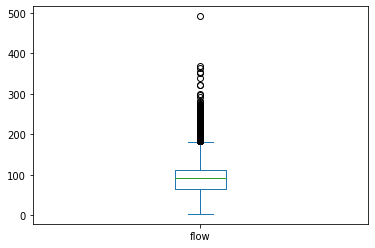

In [20]:
df.query('0 < flow < 500').flow.plot.box()

`-` 매우 큰 값 또는 작은 값이 나타난다 (계측기에 문제가 있는 것으로 보임)

`-` 0인 경우도 존재한는데 계측기의 오류 또는 모종의 이유로 물이 흐르지 않은 것으로 보인다 (i.g. 배수지 청소로 인해 단수)

`-` 이런 경우 적산차값만 사용해 예측하는 것은 불가능하므로 이상치로 처리하겠다  

`-` 한편, 큰 양수의 경우 이상치의 기준은 300을 넘지 않는 값 중 최댓값으로 하겠다 (위의 box-plot에 기반함, IQR을 넘는 값들을 보면 300부터 절단되어 빈도수가 작아짐)

`-` 이상치와 결측치는 계절성을 고려하여 전날 같은 시각의 적산차값으로 대체하겠다

In [21]:
def outlier2na(
    time_series: pd.Series, 
    *, 
    minimum: float = 0.0, 
    maximum: float = np.inf
) -> pd.Series:
    time_series = time_series.copy()
    time_series = time_series.apply(lambda x: x if minimum < x <= maximum else np.nan)
    return time_series


def fillna_seasonality(time_series: pd.Series, period: int = 24) -> pd.Series:
    """period 시점 앞의 값으로 결측치를 재귀적으로 채우고 데이터를 반환"""
    assert time_series.ndim == 1
    time_series = time_series.copy()  # 원본이 변하지 않도록 복제 
    na_idx = time_series[time_series.isnull()].index.values
    fill_idx = na_idx - period  # period 시점 앞의 값으로 결측치를 채운다
    fill_idx = np.where(fill_idx < 0, fill_idx + period, fill_idx)

    if not na_idx.size:                  # 결측치가 존재하지 않으면 원본을 반환
        return time_series
    if np.in1d(fill_idx, na_idx).all():  # 모든 결측치에 대해 period 시점 앞의 값이 결측치면 원본을 반환
        return time_series

    time_series[na_idx] = time_series[fill_idx]
    return fillna_seasonality(time_series, period)


def fillna(time_series: pd.Series, period: int = 24) -> pd.Series:
    return fillna_seasonality(time_series, period).fillna(method='ffill').fillna(0)

In [22]:
# 이상치는 결측치로 처리한다
cut_max_value = 300 
df_max = df.flow[df.flow < cut_max_value].max()
df['flow'] = outlier2na(df['flow'], maximum=df_max)
test['flow'] = outlier2na(test['flow'], maximum=df_max)
private['flow'] = outlier2na(private['flow'], maximum=df_max)

In [23]:
# 결측치는 계절성을 고려하여 전날 같은 시각의 적산차값으로 채운다 
df['flow'] = fillna(df['flow'])
test['flow'] = fillna(test['flow'])
private['flow'] = fillna(private['flow'])

In [24]:
private = private[private.datetime >= start].reset_index(drop=True)

## 시각화 (모델 학습과 무관)

`-` **모델 학습과 무관한 파트입니다**

`-` **생략하셔도 코드 실행에 문제가 없습니다**

In [25]:
sns.set_theme(style='white')

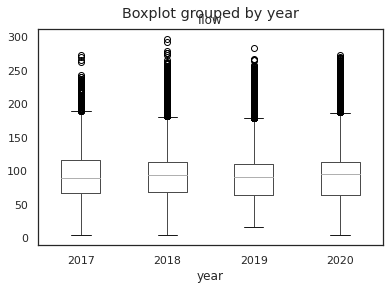

In [26]:
# 연도별 적산차의 분포
df.assign(year = df.datetime.dt.year).boxplot(column='flow', by='year', grid=False)

`-` 적산차의 경우 2017년과 나머지 연도는 다른 분포를 띄고있다 (평균과 분산이 더 커졌다)

`-` 모델 훈련에 2017년 데이터를 사용하지 않겠다

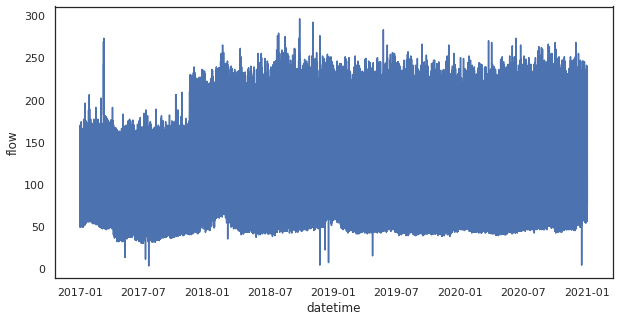

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x='datetime', y='flow', data=df, ax=ax)

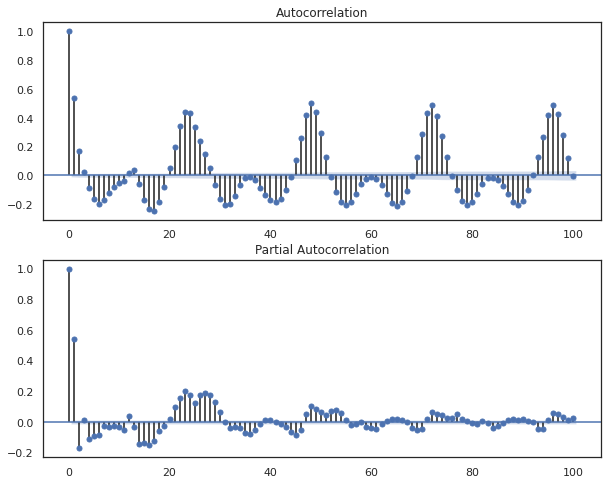

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
sgt.plot_acf(df['flow'], lags = 100, ax=ax1);
sgt.plot_pacf(df['flow'], lags = 100, ax=ax2);

`-` 그래프에 2017년을 제외하면 추세는 존재하지 않고 강한 계절성이 존재한다

`-` ACF, PACF의 정의에 따라 0시점 차이는 의미가 없으므로 무시한다

`-` 계절성이 매우 강하다

`-` 사이클(W 모양)이 대략 24시간 마다 반복되므로 최소 24시간 분량의 변수를 모델의 입력으로 사용해야 한다

- 고점 판단

`-` 시각화하면 알 수 있는데 고점은 하루에 2번 나타난다 (9시 부근, 20시 부근, 나머지는 잡음으로 생각)

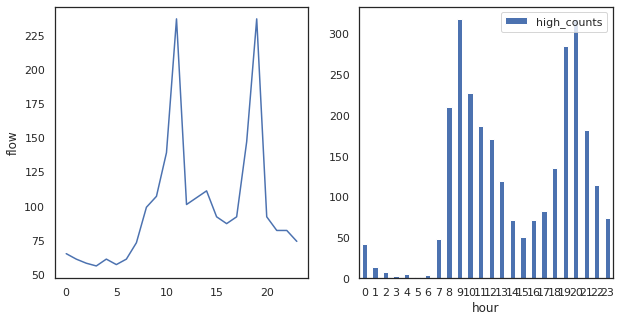

In [29]:
high_value = np.quantile(df['flow'].values, q=1-2/24)  # 하루에 고점은 2번 (시각화로 확인함)

# 하루 24시간 적산차의 변화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(data=df['flow'].iloc[-24:].reset_index(drop=True), ax=ax1)


# 고점의 분포
df.assign(year = df.datetime.dt.year).query('year > 2017').\
assign(is_high = (df.flow > high_value).astype(int)).\
assign(hour = df.datetime.dt.hour).\
groupby('hour').agg(high_counts=('is_high', np.sum)).\
reset_index().plot.bar(x='hour', y='high_counts', rot=0, ax=ax2)

`-` 모델 학습에서 가장 큰 문제점은 고점이 언제인지 판단하는 것이다

## 학습 및 예측에 사용할 함수 선언

In [24]:
!git clone https://github.com/ts-kim/RevIN.git

Cloning into 'RevIN'...
remote: Enumerating objects: 181, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 181 (delta 62), reused 93 (delta 20), pack-reused 0
Receiving objects: 100% (181/181), 2.84 MiB | 15.15 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from torch.nn.modules.loss import _Loss
from torch.optim import Optimizer

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

from RevIN.RevIN import RevIN  # RevIN 폴더안에 있는 RevIN.py 안에 있는 RevIN 클래스를 import

- 학습 방법

`-` 96시간의 적산차를 이용해 다음 시점을 포함하여 336시간 분량의 적산차를 예측하는 모델을 적합

- 데이터 형태 변경

In [31]:
def ts_train2supervised(
    ts: NDArray[np.float_], 
    window: int = 24,
    gap: int = 1, 
    step: int = 336
) -> Tuple[NDArray[np.float_], NDArray[np.float_]]:
    assert ts.ndim == 2 and ts.shape[1] == 1
    X, y = [], []
    for t in range(len(ts) - (window+gap+step) + 2):
        X.append(ts[t:t+window])
        y.append(ts[t+window+gap-1 : t+window+gap+step-1])
    X, y = np.array(X), np.array(y)  
    return X, y

In [32]:
def ts_test2supervised(
    ts: NDArray[np.float_], 
    window: int = 24
) -> NDArray[np.float_]:
    assert ts.ndim == 2 and ts.shape[1] == 1
    X = []
    for t in range(len(ts) - window + 1):
        X.append(ts[t:t+window])
    X = np.array(X)
    return X

- 난수 고정

In [33]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False  

In [34]:
def clear_gpu() -> None:
    gc.collect()
    torch.cuda.empty_cache()

- 피쳐 스케일링

`-` 0 ~ 1 사이로 정규화

In [35]:
minmax_scaler = MinMaxScaler()
flow_scaled = minmax_scaler.fit_transform(df['flow'].values.reshape(-1, 1))  
flow_scaled_test = minmax_scaler.transform(test['flow'].values.reshape(-1, 1))   
flow_scaled_private = minmax_scaler.transform(private['flow'].values.reshape(-1, 1))   

- 데이터 셋과 데이터 로더

In [36]:
class CustomDataset(Dataset):
    def __init__(self, X: NDArray[np.float_], y: Optional[NDArray[np.float_]] = None) -> None:
        super(CustomDataset, self).__init__()
        self.X = X
        self.y = y

    def __getitem__(self, idx: int) -> Union[Tuple[Tensor, Tensor], Tensor]:
        X = torch.FloatTensor(self.X[idx])
        if self.y is not None:
            y = torch.FloatTensor(self.y[idx])
            return X, y
        return X

    def __len__(self) -> int:
        return self.X.shape[0]

In [37]:
def get_dataloader(
    X: NDArray[np.float_], 
    y: Optional[NDArray[np.float_]] = None, 
    batch_size: int = 64, 
    shuffle: bool = True
) -> DataLoader:
    dataset = CustomDataset(X, y)    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

- 조기 중단

In [38]:
# ref: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """주어진 patience 횟수 이후로 validation score가 개선되지 않으면 학습을 조기 중단"""
    mode_dict = {'min':-1, 'max':1}
    score_metrics = [
        'accuracy',
        'f1_score',
        'mae',
    ]

    def __init__(
        self, 
        patience: int = 7, 
        monitor: str = 'loss', 
        mode: str = 'min', 
        min_delta: float = 0.0, 
        folder_path: str = './weights', 
        model_name: str = '',
    ) -> None:
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.direction = self.mode_dict[mode]
        self.monitor = monitor
        self.best_score = -np.Inf
        self.valid_loss = np.Inf
        self.valid_metric_score = None  # 평가지표 (i.g. accuracy)
        self.early_stop = False
        self.min_delta = min_delta
        self.folder_path = folder_path    
        self.model_name = model_name
        self.reset_fold()  # for k-fold cross validation

    def __call__(
        self, 
        model: nn.Module, 
        valid_loss: float, 
        valid_metric_score: Optional[float] = None
    ) -> None:
        # score는 클수록 좋다
        if self.monitor == 'loss':
            score = valid_loss * self.direction
        elif self.monitor in self.score_metrics:
            score = valid_metric_score * self.direction
        else:
            score = None

        # score가 개선되었는지 확인
        if score <= self.best_score + self.min_delta: 
            self.counter += 1 
            if self.counter > self.patience:  # 만약 score가 개선되지 않은 에폭이 patience 횟수보다 크다면 조기 중단
                self.early_stop = True
        else: 
            self.best_score = score 
            self.save_checkpoint(model, valid_loss, valid_metric_score) 
            self.counter = 0  # score가 개선되었으므로 0으로 변경

    def save_checkpoint(
        self, 
        model: nn.Module, 
        valid_loss: float, 
        valid_metric_score: Optional[float] = None
    ) -> None:
        """validation score가 개선되면 모델을 저장"""
        torch.save(model.state_dict(), self.path) 
        self.valid_loss = valid_loss  # 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.valid_metric_score = valid_metric_score  # 이때의 valid metric score도 변경

    @property
    def path(self) -> str:
        return f'{self.folder_path}/{self.model_name}_best_{self.fold}.pt'

    def reset_fold(self) -> None:
        self.fold = 0

    def update_fold(self) -> None:
        self.fold += 1

    def reset_score(self) -> None:
        """다음 fold 학습을 위해 score 관련 파라미터를 초기화"""
        self.counter = 0
        self.best_score = -np.Inf
        self.valid_loss = np.Inf
        self.valid_metric_score = None
        self.early_stop = False

- 손실 함수

In [39]:
loss_fn = nn.L1Loss()  # MAE

- 학습 및 검증

In [40]:
def train(
    model: nn.Module,
    dataloader: DataLoader, 
    loss_fn: _Loss, 
    scaler: torch.cuda.amp.GradScaler,
    optimizer: Optimizer, 
    scheduler: Optional[_LRScheduler] = None,
    args: EasyDict = None
) -> Tuple[nn.Module, float]:
    """dataloader의 데이터로 모델을 학습시킨 후 학습된 모델과 평균 배치 훈련 오차를 반환"""  
    train_loss = 0.0
    model.to(args.device)
    model.train()

    for X, y in dataloader:  
        X, y = X.to(args.device), y.to(args.device) 
        with torch.cuda.amp.autocast():
            y_hat = model(X)
            loss = loss_fn(y_hat, y)  

        optimizer.zero_grad()  
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=args.max_norm)
        scaler.step(optimizer)
        scaler.update()
        train_loss += (loss.item() / len(dataloader)) 
  
    # 에폭마다 학습률 조절
    if scheduler is not None:
        scheduler.step()
        
    return model, train_loss

In [41]:
def evaluate(
    model: nn.Module, 
    dataloader: DataLoader, 
    loss_fn: _Loss,
    args: EasyDict
) -> Tuple[float, float]:
    """dataloader의 데이터를 모델이 평가한 후 평균 배치 검증 오차와 MAE를 반환"""
    valid_loss = 0.0
    y_array, yhat_array = np.array([]).reshape(0, args.num_classes), np.array([]).reshape(0, args.num_classes)
    model.to(args.device)
    model.eval()  

    with torch.no_grad():  
        for X, y in dataloader:  
            X, y = X.to(args.device), y.to(args.device) 
            with torch.cuda.amp.autocast():
                y_hat = model(X)
                loss = loss_fn(y_hat, y)
                  
            y = y.detach().cpu().numpy()  
            y_hat = y_hat.detach().cpu().numpy()  
            y_array = np.concatenate([y_array, minmax_scaler.inverse_transform(y)])
            yhat_array = np.concatenate([yhat_array, minmax_scaler.inverse_transform(y_hat)])
            valid_loss += (loss.item() / len(dataloader))

    valid_mae = mean_absolute_error(y_array, yhat_array)        
    return valid_loss, valid_mae

In [42]:
def kfold_cross_validate(
    model: nn.Module, 
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    loss_fn: _Loss, 
    early_stopping: EarlyStopping,
    args: EasyDict 
) -> Tuple[nn.Module, List[List[float]], List[List[float]]]:
    """K겹 교차검증을 통해 모델의 성능을 평가하고 학습된 모델과 폴드별 훈련 손실, 검증 손실을 반환"""
    seed_everything(args.seed)   # 정확한 재현을 위함
    fold_valid_loss = []         # 폴드별 best 검증 손실
    fold_valid_mae = []          # 폴드별 best 검증 MAE
    fold_train_losses_per_epoch = [[] for _ in range(args.num_folds)]  # 폴드별 1 에폭에 따른 훈련 배치 손실
    fold_valid_losses_per_epoch = [[] for _ in range(args.num_folds)]  # 폴드별 1 에폭에 따른 검증 배치 손실
    early_stopping.reset_fold()  # 폴드 순서 0 번째로 초기화
    tscv = TimeSeriesSplit(n_splits=args.num_folds)     

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        print(f'[{fold + 1} / {args.num_folds}] Fold Training......')

        # 메모리 절약
        clear_gpu()

        # 훈련 데이터와 검증 데이터로 분할
        X_train, y_train = X[train_idx], y[train_idx] 
        X_val, y_val =  X[val_idx], y[val_idx]

        # Dataloader
        train_dataloader = get_dataloader(X_train, y_train, args.bs)
        valid_dataloader = get_dataloader(X_val, y_val, args.bs, shuffle=False)

        # optimizer
        optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay) 

        # scheduler
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.lr_gamma)

        # grad scalder
        scaler = torch.cuda.amp.GradScaler()

        # early stopping, 다음 폴드 학습을 위해 score 관련 파라미터 초기화
        early_stopping.reset_score()
        early_stopping.update_fold()  
        
        # 폴드마다 모델 학습
        for epoch in tqdm(range(1, args.num_epochs+1)):  # (배치사이즈 * 에폭) 만큼 훈련시킴           
            model, train_loss = train(model, train_dataloader, loss_fn, scaler, optimizer, scheduler, args)  # 모델 학습
            valid_loss, valid_mae = evaluate(model, valid_dataloader, loss_fn, args)  # 모델 평가
            fold_train_losses_per_epoch[fold].append(train_loss) 
            fold_valid_losses_per_epoch[fold].append(valid_loss)  

            print_score_condition = (epoch == 1 or epoch % 10 == 0 or epoch == args.num_epochs)  
            score_information = f'[Epoch: {epoch:>2}]  train loss = {train_loss:.5f}  valid loss = {valid_loss:.5f}  valid MAE = {valid_mae:.5f}'

            # 평균 배치 훈련 오차와 검증 오차 출력
            if print_score_condition:  
                print(score_information)  
                
            # 에폭마다 early stopping 실행
            early_stopping(model, valid_loss, valid_mae)  
            if early_stopping.early_stop: 
                if not print_score_condition:  # 이미 출력한 에폭에 대해 중복으로 출력하지 않기 위함
                    print(score_information) 
                print('Early Stopping!')
                break 

        fold_valid_loss.append(early_stopping.valid_loss)         # 폴드별 best 검증 손실
        fold_valid_mae.append(early_stopping.valid_metric_score)  # 폴드별 best 검증 MAE

        # 폴드 학습 및 검증 종료시 best 검증 손실과 매트릭 스코어를 출력
        print(f'{fold + 1} Fold Best -> Valid Loss: {early_stopping.valid_loss:.5f} Valid MAE: {early_stopping.valid_metric_score:.5f}', end='\n'*2)
      
    # 폴드별 best 모델의 평균 검증 손실과 평균 매트릭 스코어를 출력
    print(f'{args.num_folds} Fold Mean Valid Loss: {np.mean(fold_valid_loss):.5f}')
    print(f'{args.num_folds} Fold Mean Valid Accuracy: {np.mean(fold_valid_mae):.5f}')
    return model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch

- 에폭에 따른 손실의 변화

In [43]:
def show_loss_plot(
    fold_train_losses: List[List[float]],
    fold_valid_losses: List[List[float]]
) -> None:
    """폴드별로 에폭에 따른 모델의 훈련 손실과 검증 손실의 변화를 시각화"""
    assert len(fold_train_losses) == len(fold_valid_losses)
    num_folds = len(fold_train_losses)
    ncols = 3
    nrows = 1 + (num_folds - 1)//ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4)) 

    # 폴드마다 에폭에 따른 훈련 손실과 검증 손실의 변화를 시각화
    for fold, (ax, train_losses, valid_losses) in enumerate(zip(axes.flatten(), fold_train_losses, fold_valid_losses), start=1):
        assert len(train_losses) == len(valid_losses) 
        if fold > num_folds:
            break

        num_epochs = len(train_losses)
        ax.set_title(f'{fold} Fold')
        ax.plot(range(1, num_epochs+1), train_losses, label='Train')
        ax.plot(range(1, num_epochs+1), valid_losses, label='Valid')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()

    fig.suptitle('Train Loss and Valid Loss', x=0.51, y=1.05, fontsize=15)
    fig.tight_layout()

    # 남는 서브 플랏 제거
    for ax in axes.flatten():
        if not ax.has_data():
            fig.delaxes(ax)

- Test 예측

In [44]:
def predict(
    model: nn.Module, 
    X: NDArray[np.float_],
    weight_folder_path: str,
    args: EasyDict
) -> Tensor:   
    weight_paths = glob(weight_folder_path + '/*.pt')
    dataloader = get_dataloader(X, shuffle=False)
    test_preds = torch.zeros(len(dataloader.dataset), args.num_classes)  
    num_folds = len([weight_path for weight_path in weight_paths if args.model_name in weight_path])
     
    for weight_path in tqdm(weight_paths):
        if args.model_name not in weight_path:
            continue
            
        preds = np.array([]).reshape(0, args.num_classes)
        model.load_state_dict(torch.load(weight_path, map_location=args.device))
        model.to(args.device)
        model.eval()

        with torch.no_grad(): 
            for X in dataloader:  # test 데이터는 라벨(y)이 없다
                X = X.to(args.device)  
                y_hat = model(X).detach().cpu().numpy()   
                preds = np.concatenate([preds, y_hat]) 

        test_preds += (preds / num_folds) 
    return test_preds     

- 후처리

`-` 훈련 데이터를 보면 적산차값이 모두 정수형이다

`-` 예측값도 반올림하여 정수로 만들어주겠다

`-` 최솟값과 최댓값을 제한

In [45]:
MAX = df['flow'].values.max()
MIN = df['flow'].values.min()

In [46]:
def postprocessing(
    pred: NDArray[np.float_], 
    *, 
    minimum: float, 
    maximum: float
) -> NDArray[np.float_]:
    pred = np.clip(pred, minimum, maximum)
    pred = np.round(pred)
    return pred

## LSTM 모델

### 모델 학습 준비

In [47]:
args = EasyDict({
    'model_name':'lstm',
    'window':96,
    'gap':1,
    'input_size':1,
    'hidden_size':512,
    'num_layers':2,
    'dropout':0.5,
    'num_classes':336,
    'num_epochs':200,
    'num_folds':5,
    'bs':512,
    'lr':2e-3,
    'lr_gamma':0.965,
    'weight_decay':1e-2,
    'max_norm':1.0,
    'device':torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'seed':2022,
})

- 데이터 생성

In [48]:
Xs, ys = ts_train2supervised(flow_scaled, window=args.window, gap=args.gap, step=args.num_classes)  # s == scaled
Xs, ys = Xs[24*365:], ys[24*365:]  # 2017년 제거
ys = ys.squeeze(2)

### 모델 학습 및 검증

In [49]:
class LSTMModel(nn.Module):
    def __init__(
        self, 
        input_size=1, 
        hidden_size=512, 
        num_layers=2, 
        num_classes=336, 
        dropout=0.5
    ):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, 
                            hidden_size, 
                            num_layers, 
                            batch_first=True, 
                            dropout=dropout)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.revin_layer = RevIN(input_size)  

    def forward(self, x):  # shape of x: (batch, sequence, features)
        x = self.revin_layer(x, 'norm')
        hidden, _ = self.lstm(x)  
        x = self.fc(hidden[:, -1, :])  
        x = x.unsqueeze(2)  
        x = self.revin_layer(x, 'denorm')
        x = x.squeeze(2)
        return x

In [50]:
early_stopping = EarlyStopping(patience=20,
                               monitor='mae',
                               mode='min',
                               folder_path=weight_folder_path,
                               model_name=args.model_name)

In [70]:
seed_everything(args.seed)
model = LSTMModel(input_size=args.input_size, 
                  hidden_size=args.hidden_size, 
                  num_layers=args.num_layers, 
                  num_classes=args.num_classes, 
                  dropout=args.dropout)

In [71]:
model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch = kfold_cross_validate(model, Xs, ys, loss_fn, 
                                                                                       early_stopping, args)

[1 / 5] Fold Training......


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.11295  valid loss = 0.11921  valid MAE = 35.18269
[Epoch: 10]  train loss = 0.07870  valid loss = 0.07987  valid MAE = 23.51748
[Epoch: 20]  train loss = 0.07574  valid loss = 0.07727  valid MAE = 22.69758
[Epoch: 30]  train loss = 0.07452  valid loss = 0.07658  valid MAE = 22.48942
[Epoch: 40]  train loss = 0.07418  valid loss = 0.07593  valid MAE = 22.29907
[Epoch: 50]  train loss = 0.07380  valid loss = 0.07567  valid MAE = 22.22796
[Epoch: 60]  train loss = 0.07348  valid loss = 0.07524  valid MAE = 22.11024
[Epoch: 70]  train loss = 0.07317  valid loss = 0.07527  valid MAE = 22.12504
[Epoch: 80]  train loss = 0.07272  valid loss = 0.07604  valid MAE = 22.36319
[Epoch: 84]  train loss = 0.07256  valid loss = 0.07615  valid MAE = 22.39477
Early Stopping!
1 Fold Best -> Valid Loss: 0.07520 Valid MAE: 22.09275

[2 / 5] Fold Training......


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.10624  valid loss = 0.08331  valid MAE = 24.24710
[Epoch: 10]  train loss = 0.07551  valid loss = 0.07355  valid MAE = 21.41071
[Epoch: 20]  train loss = 0.07464  valid loss = 0.07135  valid MAE = 20.74943
[Epoch: 30]  train loss = 0.07375  valid loss = 0.07039  valid MAE = 20.51683
[Epoch: 40]  train loss = 0.07300  valid loss = 0.06992  valid MAE = 20.39977
[Epoch: 50]  train loss = 0.07224  valid loss = 0.07002  valid MAE = 20.43735
[Epoch: 60]  train loss = 0.07153  valid loss = 0.07051  valid MAE = 20.57359
[Epoch: 68]  train loss = 0.07116  valid loss = 0.07000  valid MAE = 20.41700
Early Stopping!
2 Fold Best -> Valid Loss: 0.06973 Valid MAE: 20.34029

[3 / 5] Fold Training......


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.11426  valid loss = 0.10084  valid MAE = 29.75482
[Epoch: 10]  train loss = 0.07446  valid loss = 0.07611  valid MAE = 22.41924
[Epoch: 20]  train loss = 0.07321  valid loss = 0.07458  valid MAE = 21.95659
[Epoch: 30]  train loss = 0.07223  valid loss = 0.07354  valid MAE = 21.65809
[Epoch: 40]  train loss = 0.07178  valid loss = 0.07384  valid MAE = 21.74023
[Epoch: 50]  train loss = 0.07105  valid loss = 0.07385  valid MAE = 21.75201
[Epoch: 60]  train loss = 0.07059  valid loss = 0.07363  valid MAE = 21.67616
[Epoch: 70]  train loss = 0.07019  valid loss = 0.07363  valid MAE = 21.68042
[Epoch: 73]  train loss = 0.07006  valid loss = 0.07391  valid MAE = 21.76437
Early Stopping!
3 Fold Best -> Valid Loss: 0.07337 Valid MAE: 21.60208

[4 / 5] Fold Training......


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.10261  valid loss = 0.08999  valid MAE = 26.39280
[Epoch: 10]  train loss = 0.07378  valid loss = 0.07621  valid MAE = 22.32692
[Epoch: 20]  train loss = 0.07247  valid loss = 0.07760  valid MAE = 22.74879
[Epoch: 30]  train loss = 0.07141  valid loss = 0.07461  valid MAE = 21.86211
[Epoch: 40]  train loss = 0.07081  valid loss = 0.07450  valid MAE = 21.79927
[Epoch: 50]  train loss = 0.06996  valid loss = 0.07464  valid MAE = 21.83670
[Epoch: 60]  train loss = 0.06946  valid loss = 0.07456  valid MAE = 21.81231
[Epoch: 66]  train loss = 0.06925  valid loss = 0.07458  valid MAE = 21.82008
Early Stopping!
4 Fold Best -> Valid Loss: 0.07438 Valid MAE: 21.77204

[5 / 5] Fold Training......


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.07848  valid loss = 0.07503  valid MAE = 21.95615
[Epoch: 10]  train loss = 0.07138  valid loss = 0.07433  valid MAE = 21.79656
[Epoch: 20]  train loss = 0.06969  valid loss = 0.07403  valid MAE = 21.71082
[Epoch: 30]  train loss = 0.06879  valid loss = 0.07434  valid MAE = 21.81018
[Epoch: 40]  train loss = 0.06812  valid loss = 0.07418  valid MAE = 21.74858
[Epoch: 43]  train loss = 0.06790  valid loss = 0.07429  valid MAE = 21.77502
Early Stopping!
5 Fold Best -> Valid Loss: 0.07395 Valid MAE: 21.70009

5 Fold Mean Valid Loss: 0.07333
5 Fold Mean Valid Accuracy: 21.50145


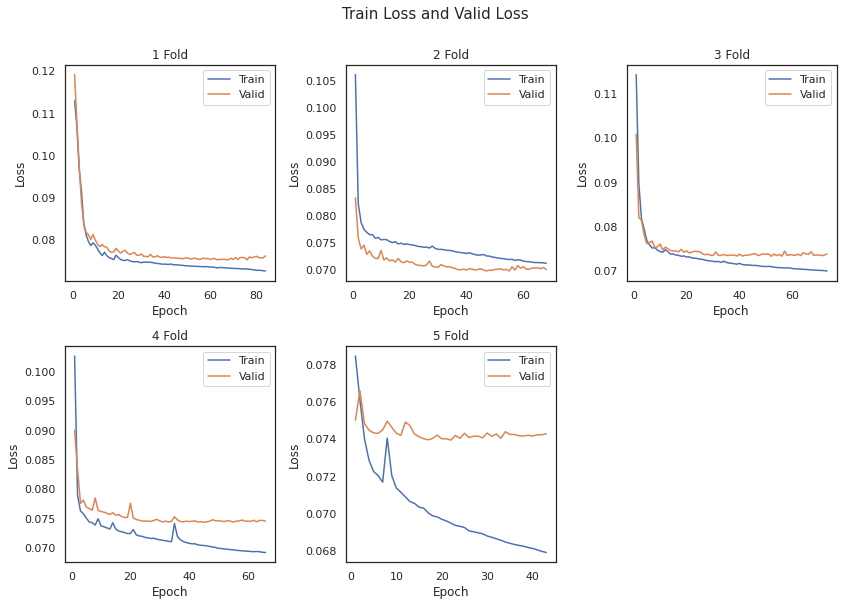

In [73]:
show_loss_plot(fold_train_losses_per_epoch, fold_valid_losses_per_epoch)  

### Test 예측

In [52]:
flow_scaled_test = np.concatenate([flow_scaled[-args.window:], flow_scaled_test])  # train + test
Xs_test = ts_test2supervised(flow_scaled_test, window=args.window)   

#### 사전학습된 가중치로 예측

In [53]:
preds = predict(model, Xs_test, pretrained_weight_folder_path, args)

  0%|          | 0/5 [00:00<?, ?it/s]

In [54]:
preds = minmax_scaler.inverse_transform(preds)
submission.loc[:, 'h0':'h335'] = postprocessing(preds, minimum=MIN, maximum=MAX)
submission.to_csv(f'./data/submission_apo_pretrained_{args.model_name}.csv', index=False)

#### 학습한 가중치로 예측

In [74]:
preds = predict(model, Xs_test, weight_folder_path, args)

  0%|          | 0/5 [00:00<?, ?it/s]

In [75]:
preds = minmax_scaler.inverse_transform(preds)
submission.loc[:, 'h0':'h335'] = postprocessing(preds, minimum=MIN, maximum=MAX)
submission.to_csv(f'./data/submission_apo_{args.model_name}.csv', index=False)

## Private 예측

In [62]:
submission_private = pd.DataFrame(pd.date_range(end, private.datetime[len(private) - 1] + pd.DateOffset(hours=1), freq='H'),
                                  columns=['datetime'])

submission_private[[f'h{t}' for t in range(336)]] = 0.0

In [63]:
flow_scaled_private = np.concatenate([flow_scaled_test[-args.window:], flow_scaled_private])  # test + private
Xs_private = ts_test2supervised(flow_scaled_private, window=args.window)   

In [64]:
preds = predict(model, Xs_private, weight_folder_path, args)

  0%|          | 0/5 [00:00<?, ?it/s]

In [65]:
preds = minmax_scaler.inverse_transform(preds[-len(submission_private):])
submission_private.loc[:, 'h0':'h335'] = postprocessing(preds, minimum=MIN, maximum=MAX)
submission_private.to_csv(f'./data/submission_private_apo_{args.model_name}.csv', index=False)